In [2]:
disp('test')


test


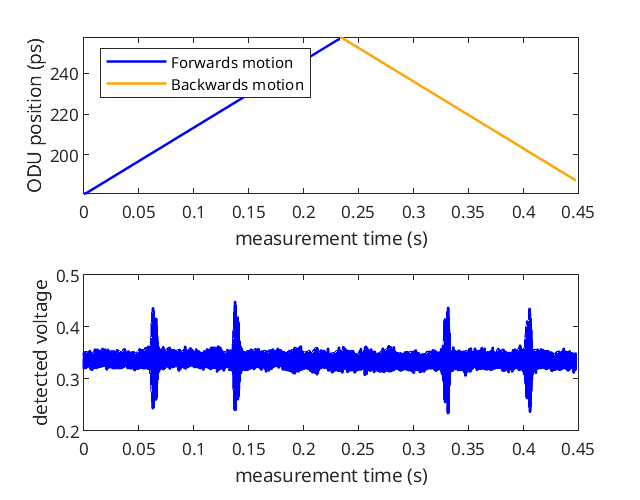

In [12]:
%plot inline -s 640,500

continuous_scan_file = './data/day10_cosf_sin2f_rapidscan.mat';  % I call continuous mode 'rapidscan' in the control program...


[path, name, ext] = fileparts(continuous_scan_file);

data = load(continuous_scan_file);


rate = data.(name).DAQ_rate;        % sampling rate (Hz)
ODU_speed = data.(name).ODU_speed;  % The final speed of the ODU in ODU units
wave0 = data.raw_data.wave0;        % Waveform of channel 0
wave1 = data.raw_data.wave1;        % Waveform of channel 1
t = data.(name).t;                  % THz time (ps)
raw_signals = data.raw_data.data;   % The raw measured signals

t_daq = (1:length(wave0))/rate;  % Time of the measurements in secs, mainly for plotting
%Sampling time

%% % The second part of the continuous data, calculate ODU position



ps_to_ODU = 3840;   % This the number that converts ODU units (probably motor steps) in to picoseconds

accel = 508000000; %Acceleration of the ODU
odu_start = ceil(ODU_speed.^2 / accel)/ps_to_ODU;

dt = 1/rate;
dt_daq = dt*ones(1, length(t_daq));
v = cumsum(dt_daq .*accel);
v(find(v>=ODU_speed))=ODU_speed; % I assumed constant acceleration until v=ODU_speed
accel_int = [diff(v) 0]; % Array to use for initial acceleration

t_ps = cumsum((v.*dt + 0.5*accel_int.*dt.^2)/ps_to_ODU) + t(1) ;

% Find where we decellerate and turn around
ind_decel = find(t_ps>t(end)+odu_start);  % No idea why it needs the odu_start....
accelerate = accel_int(find(accel_int~=0)); % Array holds only the acceleration

accel_full = accel_int;
accel_full( ind_decel(1)+(1:2*length(accelerate)) ) = -[accelerate, accelerate]; %Decelerate and turn back to -ODU_speed

v = cumsum(accel_full);
t_ps = cumsum((v.*dt + 0.5*accel_full.*dt.^2)/ps_to_ODU) + t(1) + odu_start; % Again, why it needs +odu_start is beyond me....

ind_fwd = 1:ind_decel(1)+length(accelerate); % These are indecies when the ODU is moving forward
ind_bwd = ind_fwd(end)+1:length(t_ps); % Now moving backwards.


[t_fwd, ind_fwd] = unique(t_ps(ind_fwd), 'stable'); % Just this t_fwd variable to 
% know where the ODU is a function of sampling time (t_daq)
[t_bwd, ~] = unique(t_ps(ind_bwd), 'stable'); 


% %There is a time at which the ODU is not moving backwards, but waiting....
wait_ind = find(t_daq<3800e-6);
t_bwd = t_bwd - t_bwd(wait_ind(end)) + t_bwd(wait_ind(1));



figure
subplot(2, 1, 1)
plot(t_daq(ind_fwd),t_fwd, t_daq(ind_bwd), t_bwd);
xlabel('measurement time (s)'); ylabel('ODU position (ps)');
legend({'Forwards motion', 'Backwards motion'}, 'Location', 'NorthWest');

subplot(2, 1, 2)
plot(t_daq, raw_signals);
xlabel('measurement time (s)'); ylabel('detected voltage');

# So this is the Demodulation


Previously I had my signal $E_{sig}(t)=A_0(t) \cos(\omega_0 t + \phi) + A_1(t) \cos(\omega_1 t + \phi)$, where $A_{0,1}(t)$ are the THz signals from the emitters 0 and 1 (the vertical and horizontal polarization), and $\omega_{0,1}$ are the frequencies of the two waveforms I am applying with $\omega_1 = 2 \omega_0$. 


So inorder to seperate the two signals, you use the orthogonality of the cosines. ie 
\begin{align}
    A_0(T) &=\int_0^T E_{sig}(t) \cos(\omega_0 t + \phi) dt\\
    A_0(T) &= \int_0^T \big( A_0(t) \cos(\omega_0 t + \phi) + A_1(t) \cos(\omega_1 t + \phi) \big) \cos(\omega_0 t + \phi) dt\\
    A_0(T) &= \frac{2}{T} \int_0^T A_0(t) \cos(\omega_0 t + \phi)^2 dt\\
\end{align}



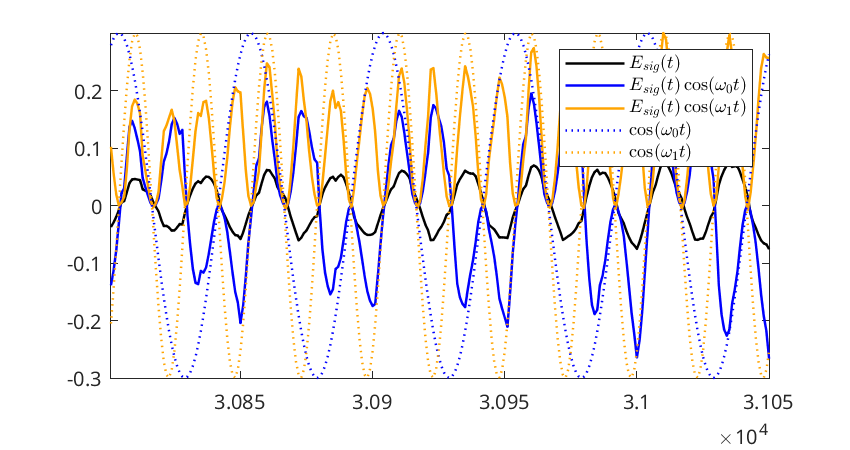

In [13]:
%plot inline -s 850,450 -r 144 -f png

%% % The third part of the script, extract the pulses

[~, t_shift] =   min(abs( t_daq - 6e-6 )) ; %There is a time delay in all the electronics

wave0s = circshift(wave0, t_shift);
wave1s = circshift(wave1, t_shift);


signal_0 = (raw_signals-mean(raw_signals)).*wave0s; % Raw signals
signal_1 = (raw_signals-mean(raw_signals)).*wave1s;



tt = (1:250)+3.08e+4; % number of points to plot
figure
plot(tt, raw_signals(tt)-mean(raw_signals), 'black'); axis tight; hold on
set(gca, 'ColorOrderIndex', 1)
l1 = plot(tt, [signal_0(tt);signal_1(tt)]*0.4, '-' ); axis tight
l2 = plot(tt, [wave0s(tt);wave1s(tt)]*0.03, ':' ); axis tight
l2(1).Color=l1(1).Color;
l2(2).Color=l1(2).Color;

legend({"$E_{sig}(t)$", "$E_{sig}(t) \cos(\omega_0 t)$", "$E_{sig}(t) \cos(\omega_1 t)$", "$\cos(\omega_0 t)$", "$\cos(\omega_1 t)$"}, 'Interpreter', 'Latex')

## Low pass filtering

In order to reduce noise, people pass these signals through a low pass filter. 


I was doing this by doing a moving average filter. This is equivalent to doing a convolution with a $rect$ function. ie. $$A_0^{filt}(t)=A_0(t) * \text{rect}(t)$$.
This however leads to problems. If we expand $A_0(t)$ via a Taylor's expansion 

\begin{align}
A_0^{filt}(t) &= \left(\sum _{n=0}^{\infty }{\frac {A_0^{(n)}(t)}{n!}}(t'-t)^{n}\right) * \text{rect}(t)\\
              &= \left(  A_0(t) + A_0^{(1)}(t)(t'-t) + A_0^{(2)}(t) (t'-t)^2/2 + ... \right) * \text{rect}(t)
\end{align}

The term $(t'-t) * \text{rect}(t)$ and the $t'-t)^2 * \text{rect}(t)$ become non-zero and these are what were causing my errors

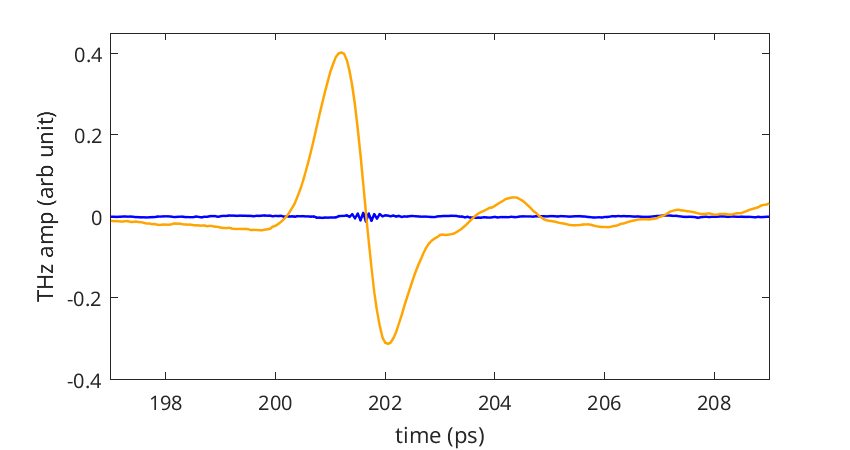

In [17]:
%plot inline -s 850,450 -r 144 -f png

% I perform some movmean smoothing to remove some noise 
f = 10000; % Frequency of the waves
p = 1/f;   % Period
n_min = int64(p/dt); % The movmean needs to be a multiple of this number. Otherwise it isn't summing over a period over which the waves are orthogonal, and that makes things messy.

% % Need to find long though, and I find suming over 0.28ps window is good
t_dt_ps = ODU_speed.*dt/ps_to_ODU;  % 
avg_length = 0.38/t_dt_ps;
% Need to do some testing where you change avg_length on line 92 and see
% when you start losing the high frequencies....

% % This is what we do now
smooth_sig0 = movmean(signal_0, n_min*ceil(1+avg_length/n_min) );
smooth_sig1 = movmean(signal_1, n_min*ceil(1+avg_length/n_min) );

% Interpolate at the temporal points we want to measure, ie at THz time.
pulse0 = interp1(t_fwd, smooth_sig0(ind_fwd), t, "makima", 0); % Forward pulses
pulse1 = interp1(t_fwd, smooth_sig1(ind_fwd), t, "makima", 0);

pulse0b = interp1(t_bwd, smooth_sig0(ind_bwd), t, "makima", NaN); % Backward pulses
pulse1b = interp1(t_bwd, smooth_sig1(ind_bwd), t, "makima", NaN);

figure
plot(t, [pulse0; pulse1]); hold on
xlim([197 209]); xlabel('time (ps)'); ylabel('THz amp (arb unit)');
ylim([-0.4 0.45]);

However, you can do convolution by the Fourier transform. Convolution theorem ${\mathcal {F}}\{f*g\}=k\cdot {\mathcal {F}}\{f\}\cdot {\mathcal {F}}\{g\}$ where $k$ is a normalization constant.

So Thierry decided to do the convolution by $ A_0(t) * \text{rect}(t) = \mathcal{F}^{-1} \big[ {\mathcal {F}}\{A_0(t)\}\cdot {\mathcal {F}}\{\text{rect}(t)\} \big] $

However, he suggested for us to use the different filter, not just a $\text{rect}$ function. So he did $\text{rect}^s(t)$ for $s$ is a number.

For $s=2$ you can show that the you original filter is the triangle function from basically $\text{tri}(x) = \text{rect}(t) * \text{rect}(t)$.


I can try a Gaussian filter $ f(t)=e^{ -4 \ln 2 t^{2}/w^{2} } $ where $w$ is the full width half maximum. It Fourier Transform is $ F_x[e^{-ax^2}](k)= e^{-\pi^2k^2/a}=   e^{-\pi^2 k^2 w^2 / (4 \ln 2)} $


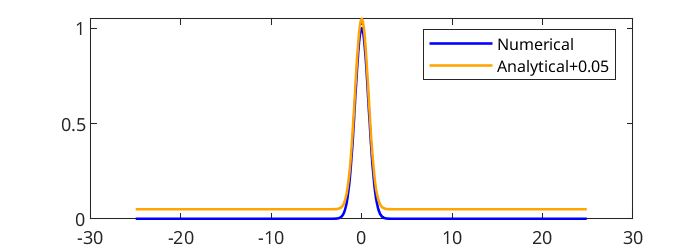

In [7]:
%plot inline -s 700,250 -r 150
% My own formulation

Ts = 1/50;
t_plt = -5:Ts:5-Ts;
K = length(t_plt);
fs = 1/Ts;

w= (-K/2:(K/2-1))*fs/K;

width=0.5;
gauss = @(t) exp( -4*log(2)*t.^2/width^2);
num_fft = fftshift(real(fft(gauss(t))));

iftG= @(w, width) (sqrt(pi * width^2 /4 /log(2) )^1 * exp( - pi^2 * w.^2 .*width^2 ./ (4*log(2)) )); % Inverse Gaussian transform

figure
plot(w, abs(num_fft/max(num_fft)), w, iftG(w, width)/max(iftG(w, width))+0.05 )
legend({'Numerical', 'Analytical+0.05'})

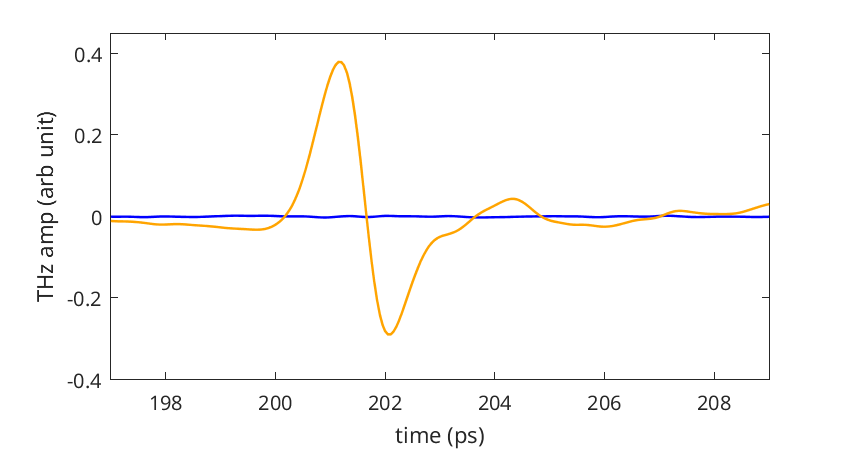

In [18]:
%plot inline -s 850,450 -r 144 -f png

% I perform some movmean smoothing to remove some noise 
f = 10000; % Frequency of the waves
p = 1/f;   % Period
n_min = int64(p/dt); % The movmean needs to be a multiple of this number. Otherwise it isn't summing over a period over which the waves are orthogonal, and that makes things messy.

% % Need to find long though, and I find suming over 0.28ps window is good
t_dt_ps = ODU_speed.*dt/ps_to_ODU;  % 
avg_length = 0.35/t_dt_ps;
% when you start losing the high frequencies....



% This is Thierry's formulation 
n0=double(n_min);
w0=f/rate*2*pi;w1=2*w0;
L=double(n_min*ceil(1+avg_length/n_min));
K=length(signal_0);
w=2*pi*(0:(K-1))/K;

dsinc=@(w,L)exp(i*w*(floor(L/2)-1)).*((w~=0).*(1-exp(-i*L*w))./(1-exp(-i*(w+(w==0))))/L+(w==0));
% this is the Fourier transform of the rect function, and which is our intergration window...

s=1; % We were previously doing s=1 according to Thierry's formulation.But s=2 or s=3 works ok. Higher numbers makes it worse
dsinc2=@(w)(dsinc(w,floor(L/s/n0)*n0) ).^s;
num_fft = dsinc2(w);


gauss = @(t, width) exp( -4*log(2)*t.^2/width^2);
num_fft = abs(fft(( gauss(-K/2:K/2-1, L) )) ); % Numerical 


w=(-K/2:K/2-1)/K;
iftG= @(w, width) (sqrt(pi * width^2 /4 /log(2) )^1 * exp( - pi^2 * w.^2 .*width^2 ./ (4*log(2)) )); % Inverse Gaussian transform
num_fft = fftshift(iftG(w, L)); % Analytical


smooth_sig0=real(ifft(fft(signal_0).*num_fft/max(num_fft) ));
smooth_sig1=real(ifft(fft(signal_1).*num_fft/max(num_fft) ));


% Interpolate at the temporal points we want to measure, ie at THz time.
pulse0 = interp1(t_fwd, smooth_sig0(ind_fwd), t, "makima", 0); % Forward pulses
pulse1 = interp1(t_fwd, smooth_sig1(ind_fwd), t, "makima", 0);

pulse0b = interp1(t_bwd, smooth_sig0(ind_bwd), t, "makima", NaN); % Backward pulses
pulse1b = interp1(t_bwd, smooth_sig1(ind_bwd), t, "makima", NaN);

figure
plot(t, [pulse0; pulse1]); hold on
xlim([197 209]); xlabel('time (ps)'); ylabel('THz amp (arb unit)');
ylim([-0.4 0.45]);


In [336]:
% 
% Load Huiliang's data

data = load("./data/data_Huiliang_2023_01_09.mat");
data = data.data_loaded;


In [130]:
%plot native


fast_scan = process_rapid_scan(data, 6, 0.15, "gauss");
slow_scan = process_rapid_scan(data, 18, 0.15, "gauss");

step_ref = data.pulses{25};
t_step = data.t{25};

[~, f_step, step_ref_FFT] = cust_fft(t_step(2)-t_step(1), [0 350], step_ref, 0.2, 3.5);

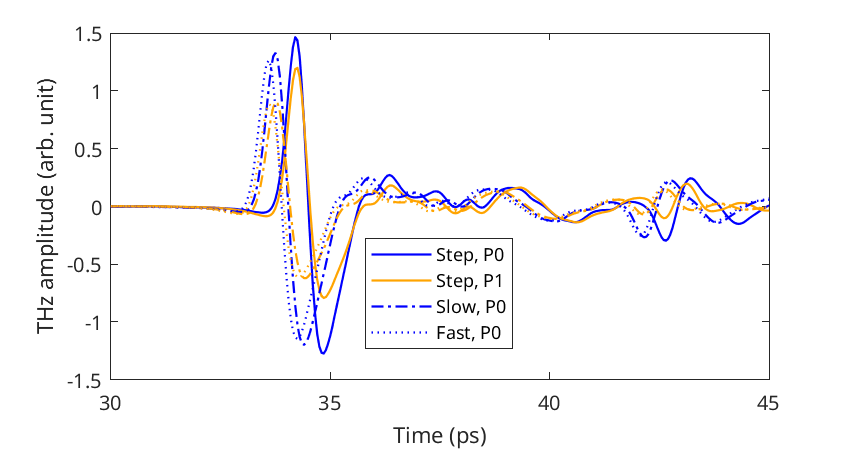

In [135]:
%plot inline -s 850,450 -r 144 -f png

figure
ref_plt = plot(t_step, step_ref); hold on
slw_plt = plot(slow_scan.t, [slow_scan.p0, slow_scan.p1]*2, '-.');
fst_plt = plot(fast_scan.t, [fast_scan.p0, fast_scan.p1]*2, ':');
% Change the colours
slw_plt(1).Color = ref_plt(1).Color; slw_plt(2).Color = ref_plt(2).Color;
fst_plt(1).Color = ref_plt(1).Color; fst_plt(2).Color = ref_plt(2).Color;
xlim([30 45])
xlabel("Time (ps)"); ylabel("THz amplitude (arb. unit)")

legend([ref_plt; slw_plt(1); fst_plt(1)], {"Step, P0", "Step, P1", "Slow, P0", "Fast, P0"}, 'Location', "Best")



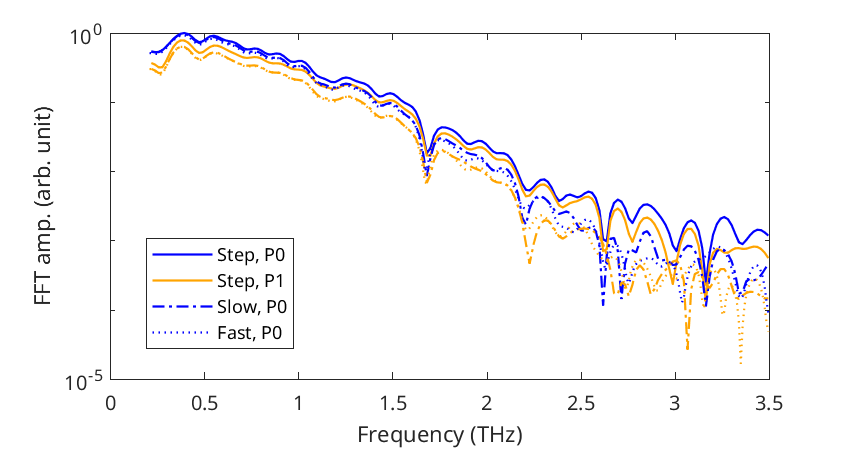

In [141]:
%plot inline -s 850,450 -r 144 -f png

% Look at the Fourier spectra

nm = max(abs(step_ref_FFT), [], 'All');

figure
ref_plt = plot(f_step, abs(step_ref_FFT)/nm ); hold on
slw_plt = plot(slow_scan.f, abs([slow_scan.f0, slow_scan.f1])*2/nm, '-.');
fst_plt = plot(fast_scan.f, abs([fast_scan.f0, fast_scan.f1])*2/nm, ':');
% Change the colours
slw_plt(1).Color = ref_plt(1).Color; slw_plt(2).Color = ref_plt(2).Color;
fst_plt(1).Color = ref_plt(1).Color; fst_plt(2).Color = ref_plt(2).Color;
% xlim([30 45])
xlabel("Frequency (THz)"); ylabel("FFT amp. (arb. unit)")
set(gca, 'YScale', 'log')

legend([ref_plt; slw_plt(1); fst_plt(1)], {"Step, P0", "Step, P1", "Slow, P0", "Fast, P0"}, 'Location', "Best")

### Gaussian Filter

In [166]:
% Calculate the Fourier spectra for different int_lengths, Gaussian Filter

int_length = linspace(0.02, 0.5, 26);
temp = process_rapid_scan(data, 18, int_length(1), "gauss");

% Create empty arrays to hold data
f = temp.f;
f0_data = zeros(length(f), length(int_length));
f1_data = zeros(length(f), length(int_length));

f0_data(:, 1) = temp.f0;
f1_data(:, 1) = temp.f1;

for i = 2:length(int_length)

    temp = process_rapid_scan(data, 18, int_length(i), "gauss");
    f0_data(:, i) = temp.f0;
    f1_data(:, i) = temp.f1;
    
end


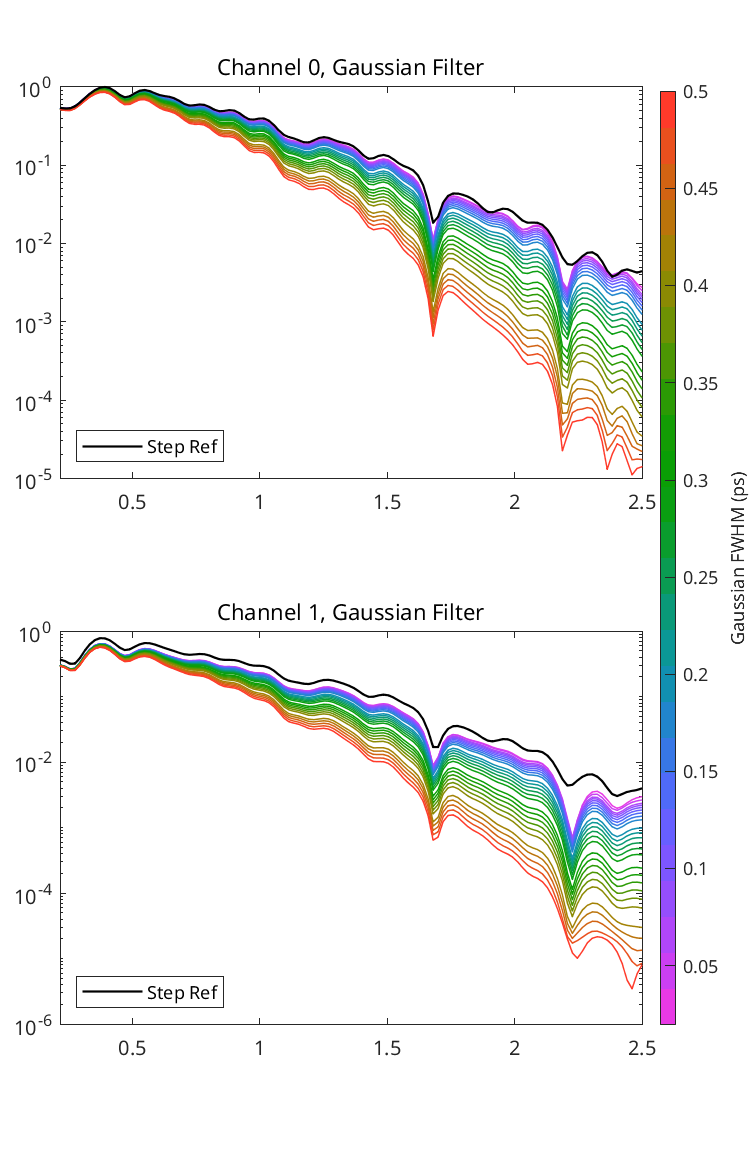

In [174]:
%plot inline -s 750,1150 -r 144 -f png


nm = max(abs(step_ref_FFT), [], 'All');
figure
ax1= subplot(2, 1, 1);
ref_plt = plot(f_step, abs(step_ref_FFT(:, 1))/nm, 'black' ); hold on
title("Channel 0, Gaussian Filter")

set(gca, 'ColorOrder', colours(length(int_length)), 'ColorOrderIndex', 1); hold on
data_plt = plot(f, abs(f0_data)*2/nm, "LineWidth", 0.75);
set(gca, 'YScale', 'log')

uistack(ref_plt,'top'); %Put the black line on the top
legend(ref_plt, "Step Ref", "Location", "SouthWest")
xlim([f_step(1), 2.5])


ax2= subplot(2, 1, 2); % For Channel Two
ref_plt = plot(f_step, abs(step_ref_FFT(:, 2))/nm, 'black' ); hold on
title("Channel 1, Gaussian Filter")

set(gca, 'ColorOrder', colours(length(int_length)), 'ColorOrderIndex', 1); hold on
data_plt = plot(f, abs(f1_data)*2/nm, "LineWidth", 0.75);
set(gca, 'YScale', 'log')

uistack(ref_plt,'top'); %Put the black line on the top
legend(ref_plt, "Step Ref", "Location", "SouthWest")
xlim([f_step(1), 2.5])


% Correct the positions
ax1.Position = ax1.Position + [-0.05 0 0 0];
ax2.Position = ax2.Position + [-0.05 0 0 0];


c = colorbar("Position", [0.88 0.11 0.02, 0.81]);
caxis([min(int_length) max(int_length)]);
colormap(ax2.ColorOrder)
xlabel(c, 'Gaussian FWHM (ps)')

It seems that the Gaussian filter with FWHM=0.18ps is the best in terms of not losing the high frequencies

### Triangle Filter

In [177]:
% Calculate the Fourier spectra for different int_lengths, Tri Filter

int_length = linspace(0.02, 0.5, 26);
temp = process_rapid_scan(data, 18, int_length(1), "tri");

% Create empty arrays to hold data
f = temp.f;
f0_data = zeros(length(f), length(int_length));
f1_data = zeros(length(f), length(int_length));

f0_data(:, 1) = temp.f0;
f1_data(:, 1) = temp.f1;

for i = 2:length(int_length)

    temp = process_rapid_scan(data, 18, int_length(i), "tri");
    f0_data(:, i) = temp.f0;
    f1_data(:, i) = temp.f1;
    
end


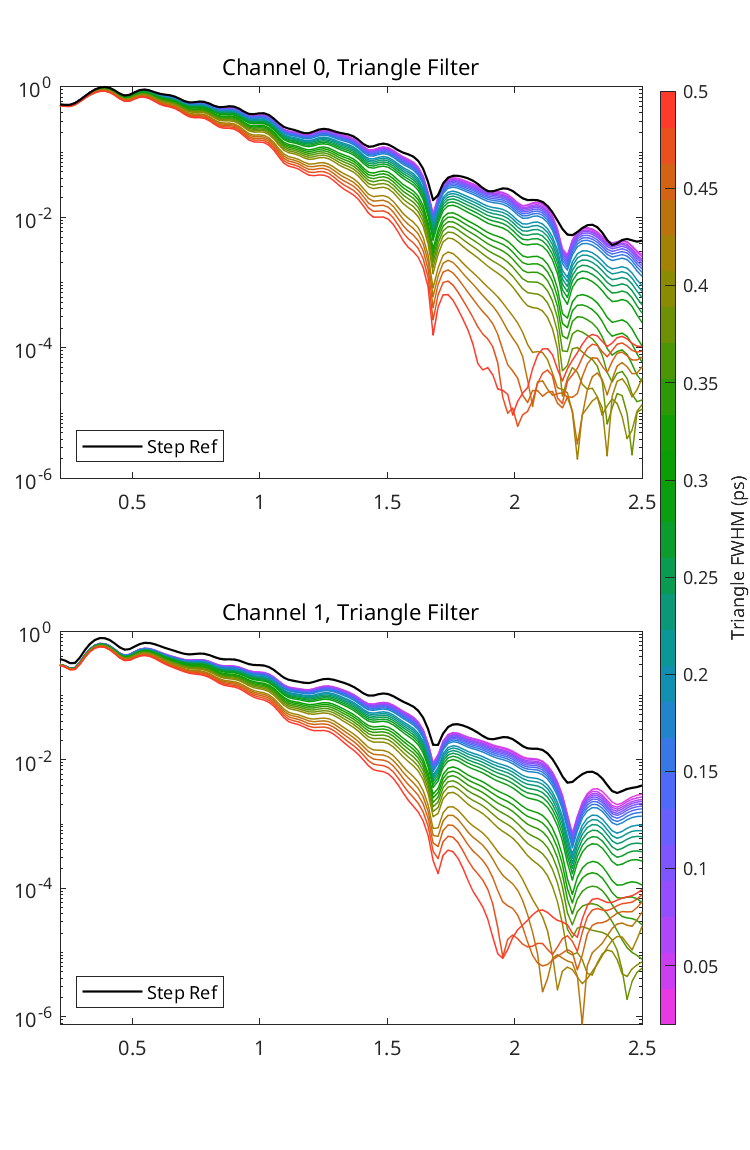

In [178]:
%plot inline -s 750,1150 -r 144 -f png


nm = max(abs(step_ref_FFT), [], 'All');
figure
ax1= subplot(2, 1, 1);
ref_plt = plot(f_step, abs(step_ref_FFT(:, 1))/nm, 'black' ); hold on
title("Channel 0, Triangle Filter")

set(gca, 'ColorOrder', colours(length(int_length)), 'ColorOrderIndex', 1); hold on
data_plt = plot(f, abs(f0_data)*2/nm, "LineWidth", 0.75);
set(gca, 'YScale', 'log')

uistack(ref_plt,'top'); %Put the black line on the top
legend(ref_plt, "Step Ref", "Location", "SouthWest")
xlim([f_step(1), 2.5])


ax2= subplot(2, 1, 2); % For Channel Two
ref_plt = plot(f_step, abs(step_ref_FFT(:, 2))/nm, 'black' ); hold on
title("Channel 1, Triangle Filter")

set(gca, 'ColorOrder', colours(length(int_length)), 'ColorOrderIndex', 1); hold on
data_plt = plot(f, abs(f1_data)*2/nm, "LineWidth", 0.75);
set(gca, 'YScale', 'log')

uistack(ref_plt,'top'); %Put the black line on the top
legend(ref_plt, "Step Ref", "Location", "SouthWest")
xlim([f_step(1), 2.5])


% Correct the positions
ax1.Position = ax1.Position + [-0.05 0 0 0];
ax2.Position = ax2.Position + [-0.05 0 0 0];


c = colorbar("Position", [0.88 0.11 0.02, 0.81]);
caxis([min(int_length) max(int_length)]);
colormap(ax2.ColorOrder)
xlabel(c, 'Triangle FWHM (ps)')

Soo both of them seem to give a best value of about FWHM = 0.19 ps. 

## Now need to compare Gaussian VS Triangle filter SNR

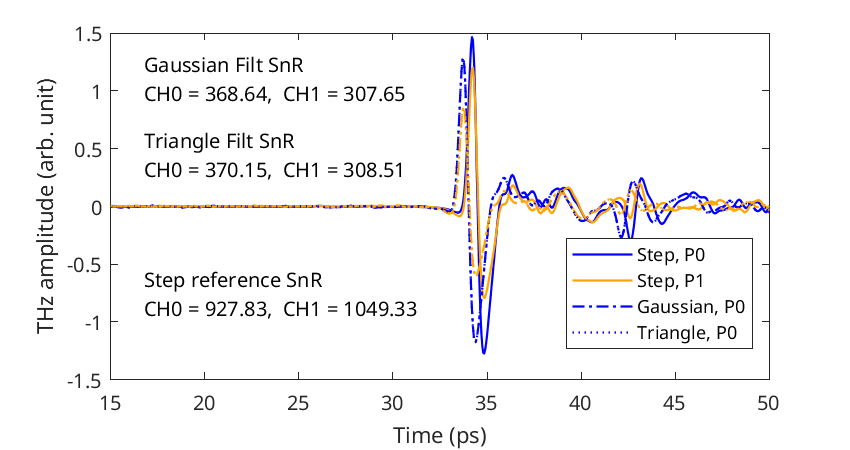

In [211]:
%plot inline -s 850,450 -r 144 -f png

gaus = process_rapid_scan(data, 18, 0.19, "gauss", "single");
tria = process_rapid_scan(data, 18, 0.19, "tri", "single");

% Get SnR
t = gaus.t;

noise_ID = find(t<29); % Indecies where you only have noise

SnR_gau0 = max(abs(gaus.p0))/std(gaus.p0(noise_ID));
SnR_gau1 = max(abs(gaus.p1))/std(gaus.p1(noise_ID));

SnR_tri0 = max(abs(tria.p0))/std(tria.p0(noise_ID));
SnR_tri1 = max(abs(tria.p1))/std(tria.p1(noise_ID));

SnR_ref0 = max(abs(step_ref(:, 1) ))/std(step_ref(noise_ID(10:end), 1));
SnR_ref1 = max(abs(step_ref(:, 2) ))/std(step_ref(noise_ID(10:end), 2));


figure
ref_plt = plot(t_step, step_ref); hold on
gau_plt = plot(t, [gaus.p0, gaus.p1]*2, '-.');
tri_plt = plot(t, [tria.p0, tria.p1]*2, ':');
% Change the colours
gau_plt(1).Color = ref_plt(1).Color; gau_plt(2).Color = ref_plt(2).Color;
tri_plt(1).Color = ref_plt(1).Color; tri_plt(2).Color = ref_plt(2).Color;
xlim([15 50])
xlabel("Time (ps)"); ylabel("THz amplitude (arb. unit)")

legend([ref_plt; gau_plt(1); tri_plt(1)], {"Step, P0", "Step, P1", "Gaussian, P0", "Triangle, P0"}, 'Location', "Best")

text(0.05, 0.87, {"Gaussian Filt SnR", sprintf("CH0 = %.2f,  CH1 = %.2f", SnR_gau0, SnR_gau1)}, 'Units', "Normalized")
text(0.05, 0.65, {"Triangle Filt SnR", sprintf("CH0 = %.2f,  CH1 = %.2f", SnR_tri0, SnR_tri1)}, 'Units', "Normalized")

text(0.05, 0.25, {"Step reference SnR", sprintf("CH0 = %.2f,  CH1 = %.2f", SnR_ref0, SnR_ref1)}, 'Units', "Normalized")


ans =

        1535



# Look at IFFTing the demultiplexing

In [213]:
%plot inline -s 640,500

continuous_scan_file = './data/day10_cosf_sin2f_rapidscan.mat';  % I call continuous mode 'rapidscan' in the control program...


[path, name, ext] = fileparts(continuous_scan_file);

data = load(continuous_scan_file);


rate = data.(name).DAQ_rate;        % sampling rate (Hz)
ODU_speed = data.(name).ODU_speed;  % The final speed of the ODU in ODU units
wave0 = data.raw_data.wave0;        % Waveform of channel 0
wave1 = data.raw_data.wave1;        % Waveform of channel 1
t = data.(name).t;                  % THz time (ps)
raw_signals = data.raw_data.data;   % The raw measured signals

t_daq = (1:length(wave0))/rate;  % Time of the measurements in secs, mainly for plotting
%Sampling time

%% % The second part of the continuous data, calculate ODU position



ps_to_ODU = 3840;   % This the number that converts ODU units (probably motor steps) in to picoseconds

accel = 508000000; %Acceleration of the ODU
odu_start = ceil(ODU_speed.^2 / accel)/ps_to_ODU;

dt = 1/rate;
dt_daq = dt*ones(1, length(t_daq));
v = cumsum(dt_daq .*accel);
v(find(v>=ODU_speed))=ODU_speed; % I assumed constant acceleration until v=ODU_speed
accel_int = [diff(v) 0]; % Array to use for initial acceleration

t_ps = cumsum((v.*dt + 0.5*accel_int.*dt.^2)/ps_to_ODU) + t(1) ;

% Find where we decellerate and turn around
ind_decel = find(t_ps>t(end)+odu_start);  % No idea why it needs the odu_start....
accelerate = accel_int(find(accel_int~=0)); % Array holds only the acceleration

accel_full = accel_int;
accel_full( ind_decel(1)+(1:2*length(accelerate)) ) = -[accelerate, accelerate]; %Decelerate and turn back to -ODU_speed

v = cumsum(accel_full);
t_ps = cumsum((v.*dt + 0.5*accel_full.*dt.^2)/ps_to_ODU) + t(1) + odu_start; % Again, why it needs +odu_start is beyond me....

ind_fwd = 1:ind_decel(1)+length(accelerate); % These are indecies when the ODU is moving forward
ind_bwd = ind_fwd(end)+1:length(t_ps); % Now moving backwards.


[t_fwd, ind_fwd] = unique(t_ps(ind_fwd), 'stable'); % Just this t_fwd variable to 

In [334]:
%plot native -s 640,500

% Shift the original waves by pi/2. This is done via the Hilbert transform.
wave0_shift = imag(hilbert(wave0));
wave1_shift = imag(hilbert(wave1));

mixed_sig0 = (raw_signals-mean(raw_signals)).*wave0; % Raw signals
mixed_sig0s = (raw_signals-mean(raw_signals)).*wave0_shift; % Raw signals


mixed_sig1 = (raw_signals-mean(raw_signals)).*wave1;
mixed_sig1s = (raw_signals-mean(raw_signals)).*wave1_shift;

sig0 = sqrt( mixed_sig0.^2 + mixed_sig0s.^2);
sig1 = sqrt( mixed_sig1.^2 + mixed_sig1s.^2);

pha0 = atan2( signal_0s, signal_0);
pha1 = atan2( signal_1s, signal_1);

signal_0 = real([sig0.*exp(1i*pha0)]);
signal_1 = real([sig1.*exp(1i*pha1)]);



In [325]:
size(pha0)


ans =

     1     1



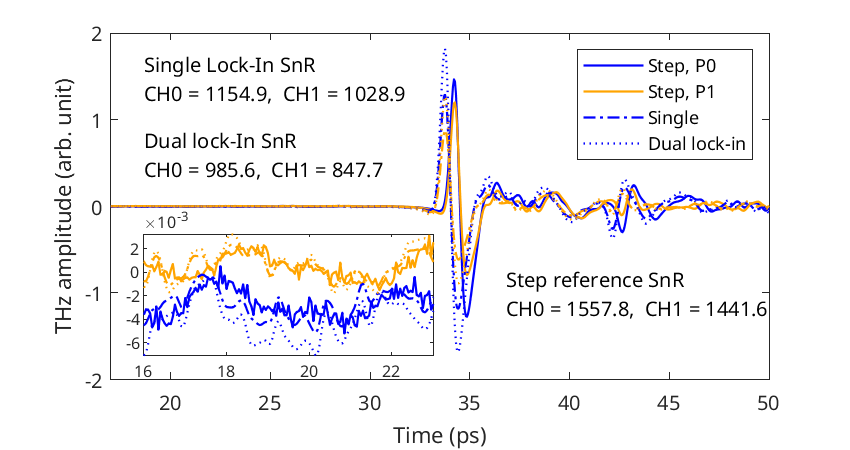

In [363]:
%plot inline -s 850,450 -r 144 -f png

sing = process_rapid_scan(data, 18, 0.19, "gauss", "single");
dual = process_rapid_scan(data, 18, 0.19, "gauss", "dual");

% Get SnR
t = dual.t;

noise_ID = find(t<24); % Indecies where you only have noise

SnR_sing0 = max(abs(sing.p0))/std(sing.p0(noise_ID));
SnR_sing1 = max(abs(sing.p1))/std(sing.p1(noise_ID));

SnR_dual0 = max(abs(dual.p0))/std(dual.p0(noise_ID));
SnR_dual1 = max(abs(dual.p1))/std(dual.p1(noise_ID));

SnR_ref0 = max(abs(step_ref(:, 1) ))/std(step_ref(noise_ID(10:end), 1));
SnR_ref1 = max(abs(step_ref(:, 2) ))/std(step_ref(noise_ID(10:end), 2));


figure
ref_plt = plot(t_step, step_ref); hold on
sing_plt = plot(t, [sing.p0, sing.p1]*2, '-.');
dual_plt = plot(t, [dual.p0, dual.p1]*2, ':');
% Change the colours
sing_plt(1).Color = ref_plt(1).Color; sing_plt(2).Color = ref_plt(2).Color;
dual_plt(1).Color = ref_plt(1).Color; dual_plt(2).Color = ref_plt(2).Color;
xlim([17 50])
xlabel("Time (ps)"); ylabel("THz amplitude (arb. unit)")

legend([ref_plt; sing_plt(1); dual_plt(1)], {"Step, P0", "Step, P1", "Single", "Dual lock-in"}, 'Location', "NorthEast")

text(0.05, 0.87, {"Single Lock-In SnR", sprintf("CH0 = %.1f,  CH1 = %.1f", SnR_sing0, SnR_sing1)}, 'Units', "Normalized")
text(0.05, 0.65, {"Dual lock-In SnR", sprintf("CH0 = %.1f,  CH1 = %.1f", SnR_dual0, SnR_dual1)}, 'Units', "Normalized")

text(0.60, 0.25, {"Step reference SnR", sprintf("CH0 = %.1f,  CH1 = %.1f", SnR_ref0, SnR_ref1)}, 'Units', "Normalized")


ax=axes("Position", [0.17 0.21 0.34 0.27]);
plot(ax, t_step, step_ref); hold on; ax.ColorOrderIndex=1;
plot(ax, t, [sing.p0, sing.p1]*2, '-.'); ax.ColorOrderIndex=1;
plot(ax, t, [dual.p0, dual.p1]*2, ':'); ax.ColorOrderIndex=1;
% Change the colours
xlim([16 23]);

In [365]:
%%file for_huiliang.m

% Load Huiliang's data

data = load("./data/data_Huiliang_2023_01_09.mat"); % Load your data here
data = data.data_loaded;


sing = process_rapid_scan(data, 18, 0.19, "gauss", "single");
dual = process_rapid_scan(data, 18, 0.19, "gauss", "dual");

% Get SnR
t = dual.t;

noise_ID = find(t<24); % Indecies where you only have noise

SnR_sing0 = max(abs(sing.p0))/std(sing.p0(noise_ID));
SnR_sing1 = max(abs(sing.p1))/std(sing.p1(noise_ID));

SnR_dual0 = max(abs(dual.p0))/std(dual.p0(noise_ID));
SnR_dual1 = max(abs(dual.p1))/std(dual.p1(noise_ID));

SnR_ref0 = max(abs(step_ref(:, 1) ))/std(step_ref(noise_ID(10:end), 1));
SnR_ref1 = max(abs(step_ref(:, 2) ))/std(step_ref(noise_ID(10:end), 2));


figure
ref_plt = plot(t_step, step_ref); hold on
sing_plt = plot(t, [sing.p0, sing.p1]*2, '-.');
dual_plt = plot(t, [dual.p0, dual.p1]*2, ':');
% Change the colours
sing_plt(1).Color = ref_plt(1).Color; sing_plt(2).Color = ref_plt(2).Color;
dual_plt(1).Color = ref_plt(1).Color; dual_plt(2).Color = ref_plt(2).Color;
xlim([17 50])
xlabel("Time (ps)"); ylabel("THz amplitude (arb. unit)")

legend([ref_plt; sing_plt(1); dual_plt(1)], {"Step, P0", "Step, P1", "Single", "Dual lock-in"}, 'Location', "NorthEast")

text(0.05, 0.87, {"Single Lock-In SnR", sprintf("CH0 = %.1f,  CH1 = %.1f", SnR_sing0, SnR_sing1)}, 'Units', "Normalized")
text(0.05, 0.65, {"Dual lock-In SnR", sprintf("CH0 = %.1f,  CH1 = %.1f", SnR_dual0, SnR_dual1)}, 'Units', "Normalized")

text(0.60, 0.25, {"Step reference SnR", sprintf("CH0 = %.1f,  CH1 = %.1f", SnR_ref0, SnR_ref1)}, 'Units', "Normalized")


ax=axes("Position", [0.17 0.21 0.34 0.27]);
plot(ax, t_step, step_ref); hold on; ax.ColorOrderIndex=1;
plot(ax, t, [sing.p0, sing.p1]*2, '-.'); ax.ColorOrderIndex=1;
plot(ax, t, [dual.p0, dual.p1]*2, ':'); ax.ColorOrderIndex=1;
% Change the colours
xlim([16 23]);

Created file '/mnt/950GiB/NSYSU_work/Research/Calculation and scripts/Dual sp emitter demodulation/for_huiliang.m'.
